In [1]:
library(MAESTRO)
library(chromVAR)
library(Seurat)
library(Matrix)
library(BSgenome.Hsapiens.UCSC.hg19)
library(BSgenome.Hsapiens.UCSC.hg38)
library(BiocParallel)
library(motifmatchr)
library(SummarizedExperiment)
# library(rhdf5)
library(dplyr)
library(motifmatchr)
library(chromVARmotifs)
library(JASPAR2016)
library(ggplot2)
# library(spam)
# library(VennDiagram)
library(stringr)
# library(ggrepel)
# library(ggsignif)
library(qs)
# register(MulticoreParam(8))



Loading required package: BSgenome

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loa

In [75]:
## this block is the function that used to perform chromVAR data analysis


# as_matrix <- function(mat){
#   tmp <- matrix(data=0L, nrow = mat@Dim[1], ncol = mat@Dim[2])
#   row_pos <- mat@i+1
#   col_pos <- findInterval(seq(mat@x)-1,mat@p[-1])+1
#   val <- mat@x
#   for (i in seq_along(val)){
#       tmp[row_pos[i],col_pos[i]] <- val[i]
#   }
#   row.names(tmp) <- mat@Dimnames[[1]]
#   colnames(tmp) <- mat@Dimnames[[2]]
#   return(tmp)
# }


RunchromVAR <- function(inputMat, min.c = 50, min.p = 500, organism = "GRCh38")
{
  message("Reading File!")
#   spam_input_matrix <- as.spam.dgCMatrix(inputMat)
  peaks <- data.frame(chr=unlist(strsplit(rownames(inputMat),'_'))[seq(1,nrow(inputMat)*3,3)], 
                 start=unlist(strsplit(rownames(inputMat),'_'))[seq(2,nrow(inputMat)*3,3)],
                 end=unlist(strsplit(rownames(inputMat),'_'))[seq(3,nrow(inputMat)*3,3)])  
  rownames(peaks) <- paste0(peaks[,1],'_',peaks[,2],'_',peaks[,3])
  peaks <- na.omit(peaks)
  message("Generating col.data!")
#   col.Data <- DataFrame(celltype=colnames(inputMat), depth=apply.spam(spam_input_matrix,2,sum))
  col.Data <- DataFrame(celltype=colnames(inputMat), depth=Matrix::colSums(inputMat))
  col.Data <- col.Data[which(col.Data[,2]>min.p),]
  message("Generating row.data!")
#   row.Data <- DataFrame(peaks=rownames(inputMat), depth=apply.spam(spam_input_matrix[,col.Data[,1]],1,sum))
  row.Data <- DataFrame(peaks=rownames(inputMat), depth=Matrix::rowSums(inputMat[,col.Data[,1]]))
  row.Data <- row.Data[which(row.Data[,2]>min.c),]
#   finalPeak <- as.matrix(peaks[row.Data[,1],])
#   finalCount <- as.matrix(inputMat[row.Data[,1],col.Data[,1]])
  finalPeak <- peaks[row.Data[,1],]
  finalCount <- inputMat[row.Data[,1],col.Data[,1]]
  rowRanges <- GRanges(as.character(finalPeak[,1]),IRanges(as.integer(finalPeak[,2]),as.integer(finalPeak[,3])),
                       strand="*",score=as.integer(5),qval=1,name=rownames(finalPeak))
  resizedRowRanges <- resize(rowRanges, width=500, fix="center")
  chromVAR_counts  = SummarizedExperiment(assays=SimpleList(counts=finalCount),rowRanges=resizedRowRanges, colData=col.Data)
  

  message("chromVAR analysis ...")
  if(organism == "GRCh38") {
     chromVAR_counts = addGCBias(chromVAR_counts, genome = BSgenome.Hsapiens.UCSC.hg38)
#      motifs <- getJasparMotifs(species = "Homo sapiens")
#      motif_ix = matchMotifs(motifs, chromVAR_counts, genome = BSgenome.Hsapiens.UCSC.hg38)
     data(human_pwms_v2)
     motif_ix = matchMotifs(human_pwms_v2, chromVAR_counts, genome = BSgenome.Hsapiens.UCSC.hg38)}
  if(organism == "GRCm38") {
     chromVAR_counts = addGCBias(chromVAR_counts, genome = BSgenome.Mmusculus.UCSC.mm10)
#      motifs <- getJasparMotifs(species="Mus musculus")
#      motif_ix = matchMotifs(motifs, chromVAR_counts, genome = BSgenome.Mmusculus.UCSC.mm10)
     data(mouse_pwms_v2)
     motif_ix = matchMotifs(mouse_pwms_v2, chromVAR_counts, genome = BSgenome.Mmusculus.UCSC.mm10)}  
  dev = computeDeviations(object = chromVAR_counts, annotations = motif_ix)
  variability = computeVariability(dev)
  zscore = assays(dev)$z
  rownames(zscore) = variability[,1]
#   variability <- computeVariability(dev)
  
  message("Finished!")
  return(list(dev = dev, zscore = zscore, variability = variability))
}


mergeChromVarResult <- function(Seurat_object, chromVAR_z_frame){
    # zframe : each row is a cell, each column is a TF/Gene
#     chromVarResult = readRDS(SeuratObject)
    p1 <- DimPlot(object = Seurat_object$ATAC, pt.size = 0.5)
    show(p1)
    Seurat_object$zscore <- chromVAR_z_frame
    Seurat_object$ATAC@meta.data <- cbind(Seurat_object$ATAC@meta.data, chromVAR_z_frame[match(rownames(Seurat_object$ATAC@meta.data), rownames(chromVAR_z_frame)),])
#     SeuratObject$ATAC@meta.data <- merge(SeuratObject$ATAC@meta.data, chromVARzframe, by="row.names", all = TRUE)
#     rownames(Seurat_object$ATAC@meta.data) <- Seurat_object$ATAC@meta.data[,1]
    for (i in colnames(chromVAR_z_frame)) {
        Seurat_object$ATAC@meta.data[i][is.na(Seurat_object$ATAC@meta.data[i])] <- min(Seurat_object$ATAC@meta.data[i], na.rm=T)
    }
    return(Seurat_object)
}



# HSC

In [ ]:
HSC.Large.peak <- Read10X_h5('/mnt/Storage2/home/dongxin/Projects/scATAC/HSC/data/h5/all_peak_count.h5')

In [56]:
HSC.Large.peak <- HSC.Large.peak[!grepl('alt',rownames(HSC.Large.peak)),]

In [59]:
HSC.Large.peak <- HSC.Large.peak.new[!grepl('random',rownames(HSC.Large.peak)),]

In [63]:
HSC.Large.peak <- HSC.Large.peak.new[!grepl('chrUn',rownames(HSC.Large.peak)),]

In [ ]:
HSC.Large.peak <- HSC.Large.peak[which(Matrix::rowSums(HSC.Large.peak)>50),]

In [88]:
writeMM(HSC.Large.peak, 'HSC/data/matrix_10X_format/matrix.mtx')
write.table(rownames(HSC.Large.peak), 'HSC/data/matrix_10X_format/all/features.tsv', row.names = F, col.names = F, quote = F)
write.table(colnames(HSC.Large.peak), 'HSC/data/matrix_10X_format/all/barcodes.tsv', row.names = F, col.names = F, quote = F)

In [93]:
HSC.result <- ATACRunSeurat(inputMat = HSC.Large.peak , 
                                project = "HSC/ATAC/HSC_scATAC", 
                                method = "LSI",
                                min.c = 50,
                                min.p = 500,
                                dims.use = 1:30,
                                cluster.res = 0.6,
                                peaks.test.use = "presto",
                                peaks.cutoff = 1e-05)
HSC.result.RP <- ATACCalculateGenescore(inputMat = HSC.Large.peak)
HSC.result$ATAC <- ATACAttachGenescore(HSC.result$ATAC, HSC.result.RP)
HSC.result$ATAC <- ATACAnnotateCelltype(HSC.result$ATAC, signatures = "human.immune.CIBERSORT", min.score = 0, genes.test.use = "presto", genes.cutoff = 1E-5, orig.ident = NULL)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
LSI analysis ...

Warning message:
“RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac”
Warning message:
“RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac”
Warning message:
“RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac”
Performing TF-IDF normalization

Running SVD on TF-IDF matrix

Scaling cell embeddings

UMAP analysis ...

19:29:59 UMAP embedding parameters a = 0.9922 b = 1.112

19:29:59 Read 26153 rows and found 30 numeric colum

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26153
Number of edges: 820121

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9281
Number of communities: 18
Elapsed time: 4 seconds


Identify cluster specific peaks ...

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Centering and scaling data matrix

Identify cluster specific genes based on RP score ...

The following `from` values were not present in `x`: ActDCs, ActMast, ActMemCD4Tcells, ActpDCs, CD8Tcells, Eosinophils, Fibroblasts, MacrophagesM1, MacrophagesM2, Myofibroblasts, NaiveBcells, Neutrophils, RestDCs, RestMast, RestMemCD4Tcells, RestNK, RestpDCs, Tfh



In [95]:
qsave(HSC.result, "HSC/ATAC/HSC.qs", nthreads = 2)
hsc_singlecell = as.SingleCellExperiment(HSC.result$ATAC)
saveRDS(hsc_singlecell, 'HSC/ATAC/HSC_single_cell_experiment.rds')

In [66]:
HSC_chromVAR <- RunchromVAR(HSC.Large.peak.new)

Reading File!

Generating col.data!

Generating row.data!

chromVAR analysis ...

Finished!



In [69]:
qsave(HSC_chromVAR, "HSC/ATAC/HSC_chromVAR.qs")

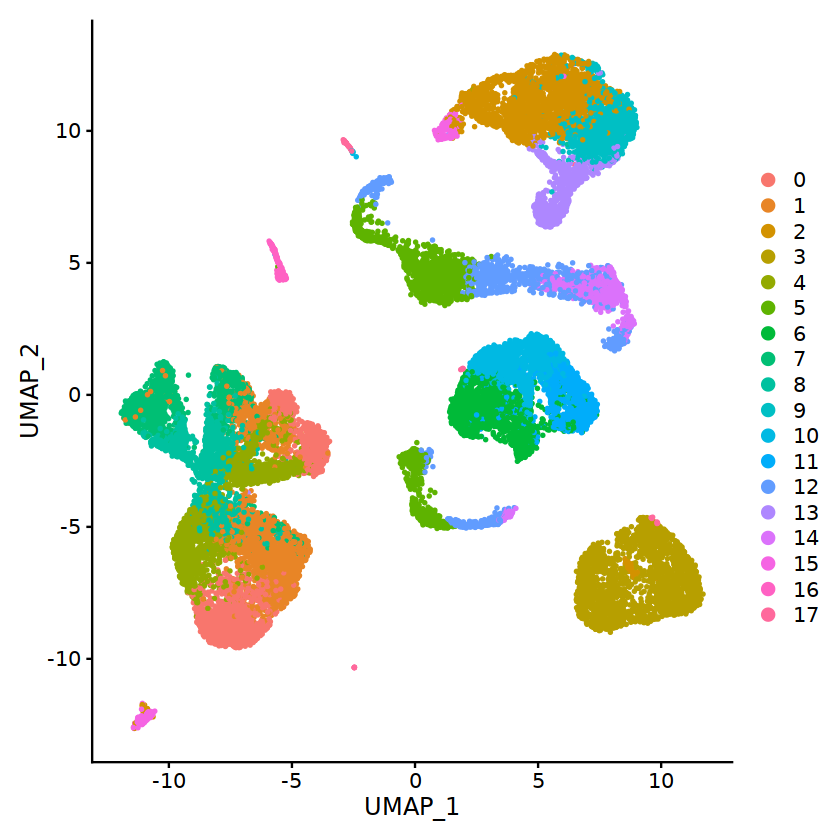

In [96]:
HSC.result.with.chromVAR <- mergeChromVarResult(HSC.result, t(HSC_chromVAR$zscore))

In [97]:
qsave(HSC.result.with.chromVAR, "HSC/ATAC/HSC_Seurat_object_chromVAR.qs")

In [98]:
TFlist = c('RFX3','BCL11A','BCL11B', 'ID4', 'EBF1', 'BRD4')

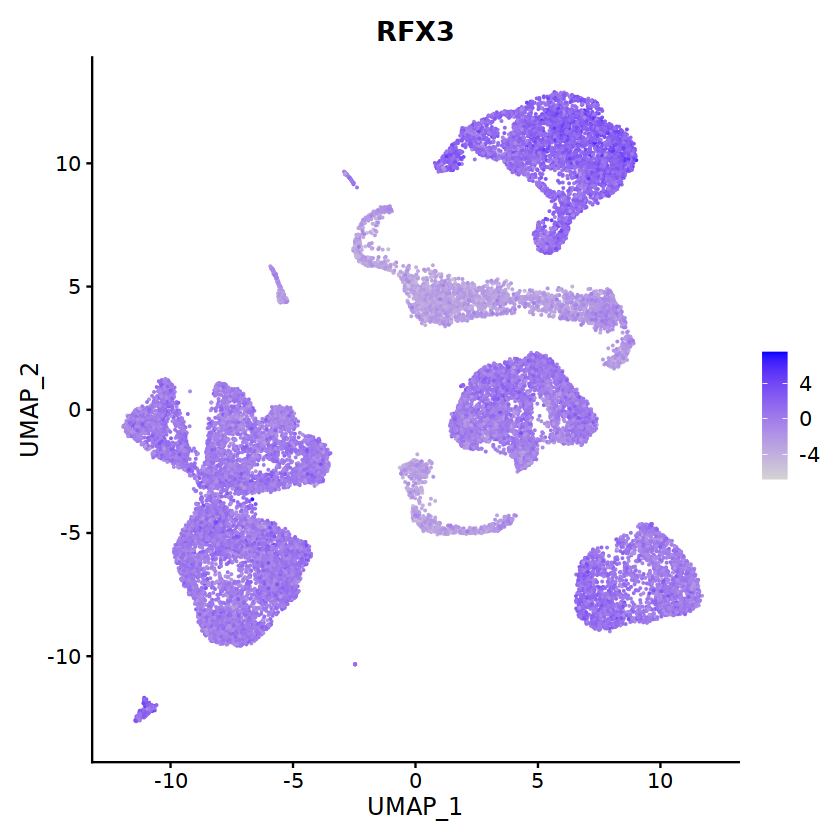

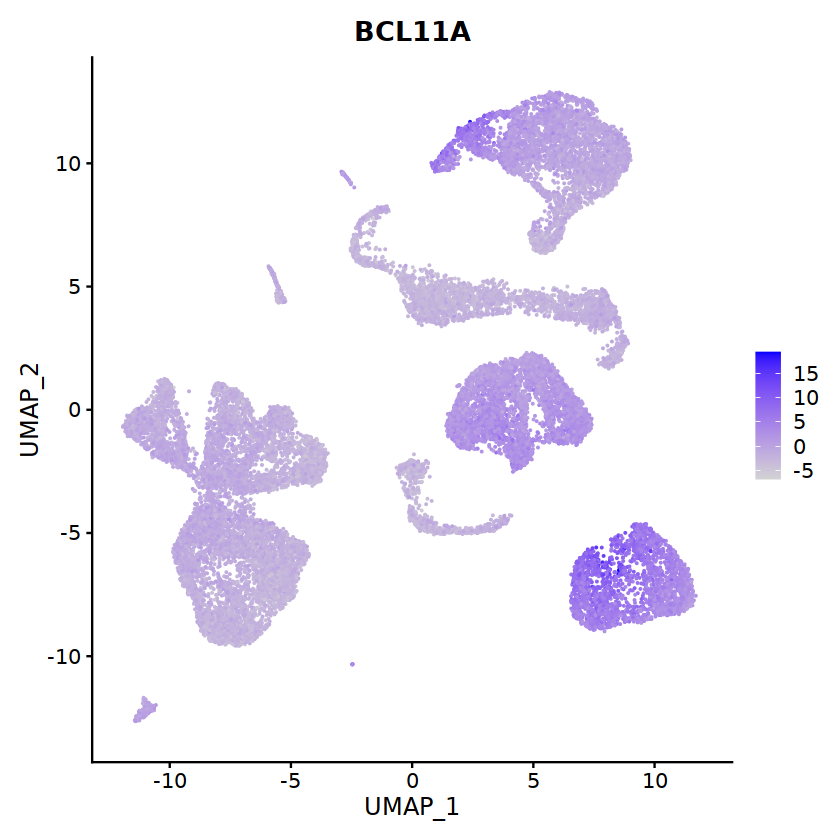

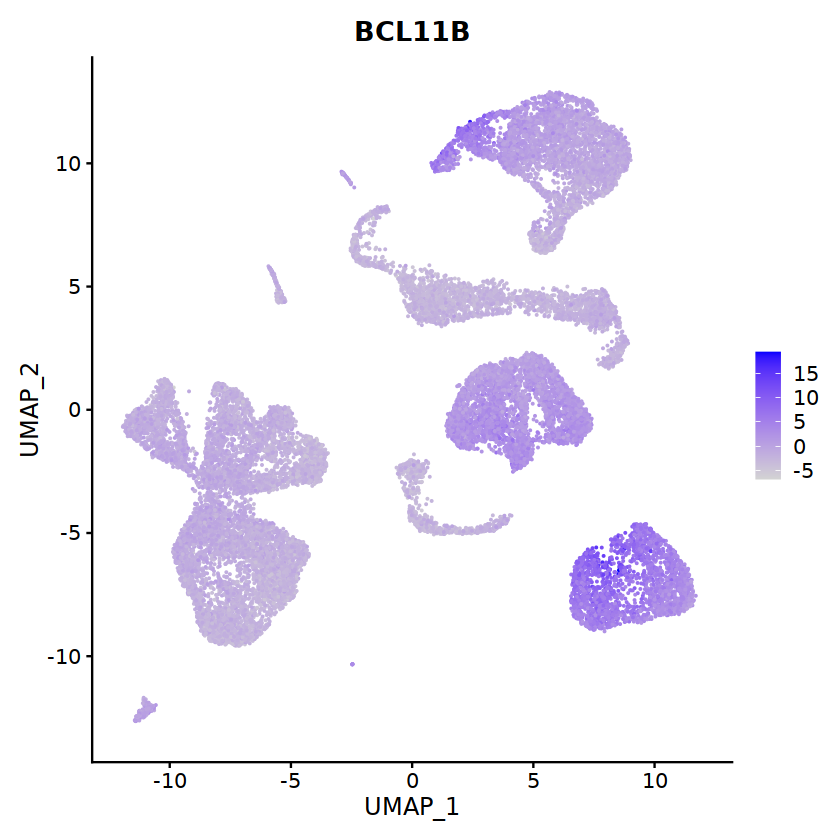

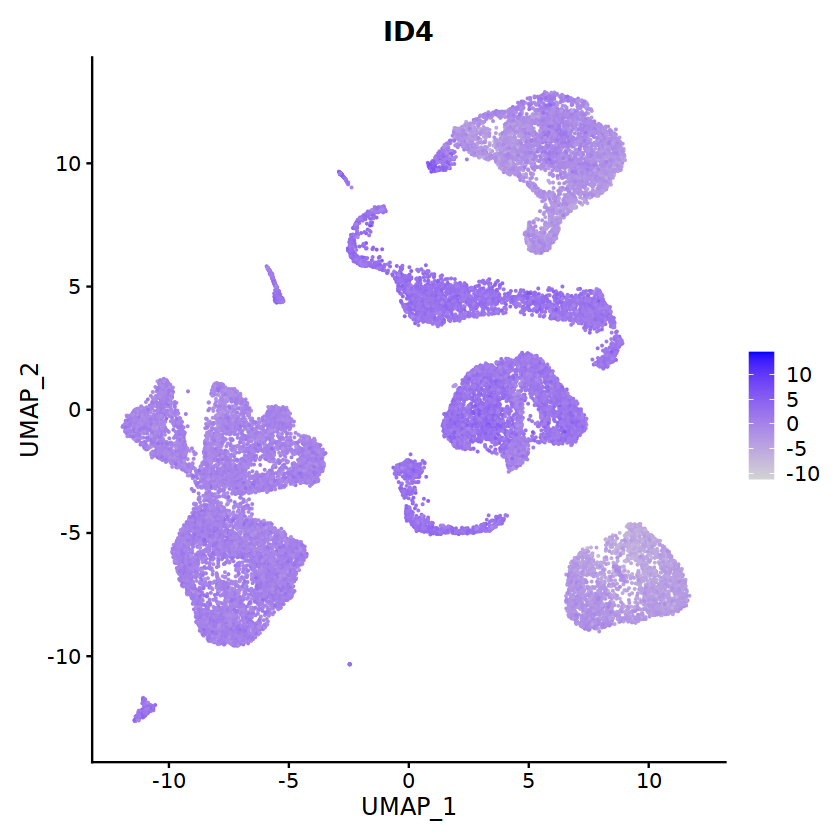

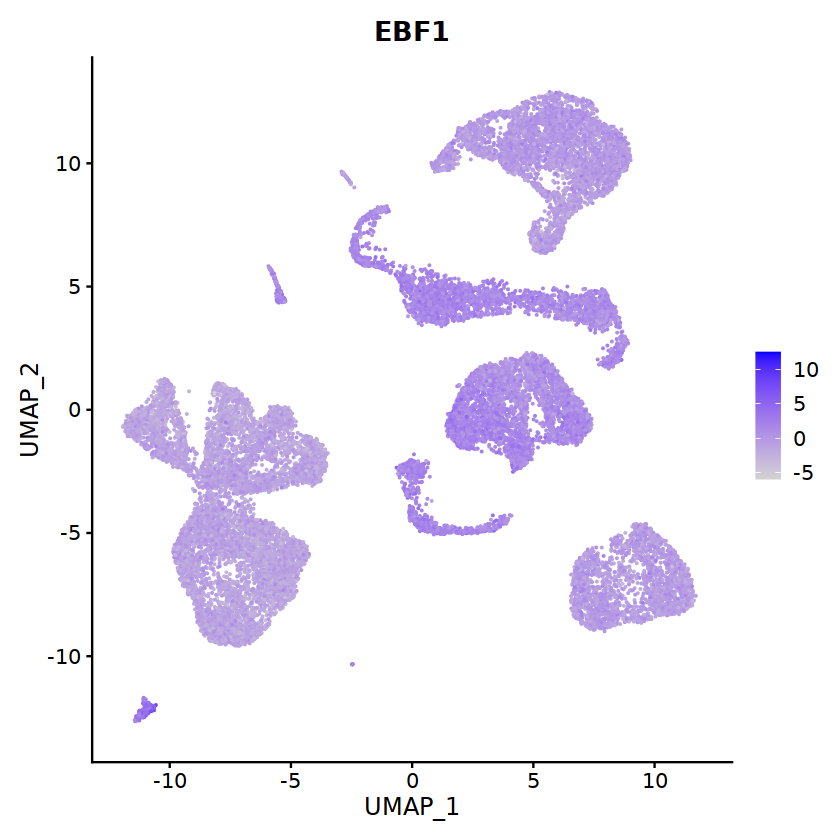

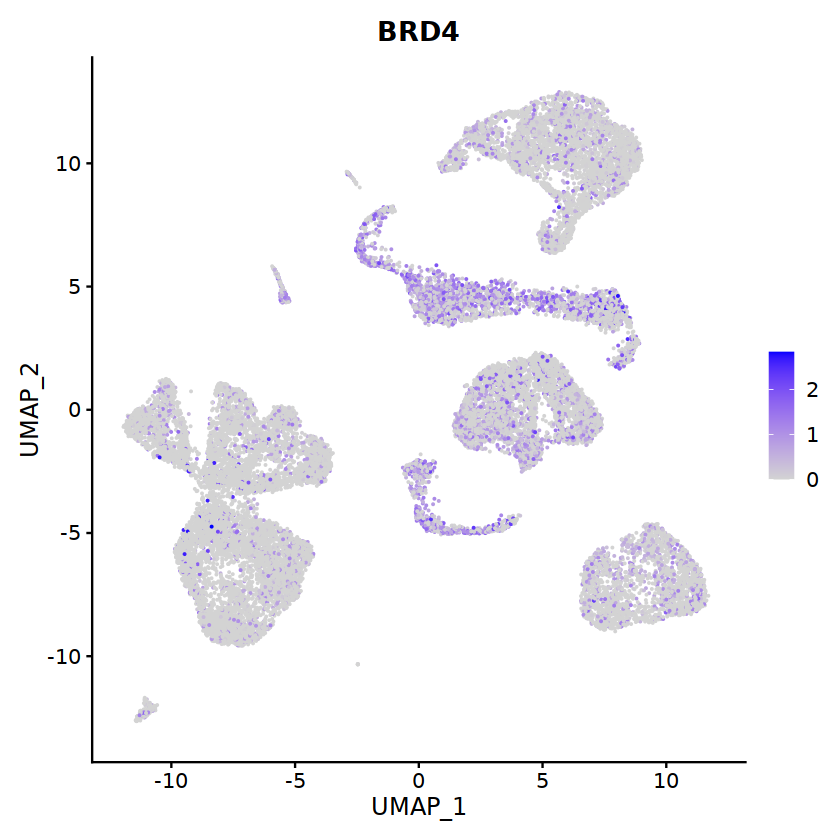

In [99]:
for (i in TFlist) {
    fig <- FeaturePlot(object = HSC.result.with.chromVAR$ATAC, feature=i)
    show(fig)
}

# BCC

## ATAC-seq

In [94]:
bcc.peak <- Read10X_h5('BCC/data/GSE129785_BCC_scATAC_peak_count.h5')
bcc.peak <- bcc.peak[which(Matrix::rowSums(bcc.peak)>50),]

In [ ]:
bcc.gene <- ATACCalculateGenescore(bcc.peak)

In [ ]:
bcc.ATAC.res <- ATACRunSeurat(inputMat = bcc.peak , 
                                project = "BCC/bcc_scATAC", 
                                method = "LSI",
                                min.c = 50,
                                min.p = 500,
                                dims.use = 1:30,
                                cluster.res = 0.6,
                                peaks.test.use = "presto",
                                peaks.cutoff = 1e-05)

bcc.ATAC.res$ATAC <- ATACAttachGenescore(bcc.ATAC.res$ATAC, bcc.gene)
bcc.ATAC.res$ATAC <- ATACAnnotateCelltype(bcc.ATAC.res$ATAC, 
                                          signatures = "human.immune.CIBERSORT", 
                                          min.score = 0.1, 
                                          genes.test.use = "presto", 
                                          genes.cutoff = 1E-5)

In [ ]:
qsave(bcc.ATAC.res, "BCC/ATAC/BCC_ATAC_GSE129785.qs", nthreads = 2)

In [ ]:
bcc.ATAC.res <- qread("BCC/ATAC/BCC_ATAC_GSE129785.qs")

In [ ]:
bcc.singlecell.experiment <- as.SingleCellExperiment(bcc.ATAC.res$ATAC)
saveRDS(bcc.singlecell.experiment, "BCC/ATAC/BCC_ATAC_single_cell_experiment.rds")

## RNA-seq

In [ ]:
# bcc <- read.table('BCC_GSE129785/GSE123813/GSE123813_bcc_scRNA_counts.txt', sep = "\t")

In [ ]:
bcc <- qread("BCC/data/GSE123813_bcc_scRNA_counts.qs")

In [ ]:
bcc.expr <- RNACountToTPM(bcc, idType = "Symbol")

In [ ]:
qsave(bcc.expr, "BCC/RNA/BCC_RNA_GSE123813_expr.qs")

In [ ]:
# bcc <- Read10X_h5('BCC_GSE129785/GSE123813_BCC_scRNA_counts.h5')
# bcc.expr <- RNACountToTPM(bcc, idType = "Symbol")
bcc.expr <- log2(bcc.expr/10+1)
bcc.RNA.res <- RNARunSeurat(inputMat = bcc.expr, 
                              project = "BCC/RNA/GSE123813_BCC_scRNA", 
                              min.c = 10,
                              min.g = 500,
                              dims.use = 1:15,
                              variable.genes = 2000, 
                              organism = "GRCh38",
                              cluster.res = 0.6,
                              genes.test.use = "presto",
                              genes.cutoff = 1e-05)
data(human.immune.CIBERSORT)
bcc.RNA.res$RNA <- RNAAnnotateCelltype(RNA = bcc.RNA.res$RNA, 
                                         gene = bcc.RNA.res$gene,
                                         signatures = human.immune.CIBERSORT, 
                                         min.score = 0.05)

In [ ]:
bcc.RNA.anno <- read.delim("BCC/data/GSE123813_bcc_all_metadata.txt")
bcc.RNA.res$RNA@meta.data <- cbind(bcc.RNA.res$RNA@meta.data, bcc.RNA.anno[match(colnames(bcc.RNA.res$RNA), bcc.RNA.anno[,1]),c(2,3,5)])
p = DimPlot(object <- bcc.RNA.res$RNA, label = TRUE, pt.size = 0.2, group.by = "cluster", label.size = 3, repel = TRUE)
ggsave(paste0(bcc.RNA.res$RNA@project.name, "_annotated_meta.png"), p, width=6.5, height=4.5)

In [ ]:
current.cluster.ids <- levels(bcc.RNA.res$RNA@meta.data$seurat_clusters)
new.cluster.ids <- c("0:CD8Teff", "1:Treg", "2:B", "3:Treg", "4:CD4Tconv", 
                       "5:Treg", "6:MonoMac", "7:Malignant", "8:CD8Teff", "9:Plasma", 
                       "10:CAF", "11:CD8Teff", "12:Malignant", "13:pDC", "14:Plasma", 
                       "15:TProliferation", "16:Endothelial", "17:Melanocyte")
# new.cluster.ids <- c("0:CD8Teff", "1:CD4Tconv", "2:B", "3:CD4Tconv", "4:Treg", 
#                        "5:CD8Teff", "6:CD8Teff", "7:Malignant", "8:mDC", "9:Plasma", 
#                        "10:MonoMac", "11:CAF", "12:TProliferation", "13:pDC", "14:Malignant", 
#                        "15:Plasma", "16:Endothelial", "17:CAF", "18:Melanocyte")
assign.ident.mannual <- plyr::mapvalues(x = bcc.RNA.res$RNA@meta.data$seurat_clusters, from = current.cluster.ids, to = new.cluster.ids)
bcc.RNA.res$RNA@meta.data$assign.ident.CIBERSORT = bcc.RNA.res$RNA@meta.data$assign.ident
bcc.RNA.res$RNA@meta.data$assign.ident = assign.ident.mannual
p = DimPlot(object = bcc.RNA.res$RNA, label = TRUE, pt.size = 0.2, group.by = "assign.ident", label.size = 3, repel = T)
ggsave(paste0(bcc.RNA.res$RNA@project.name, "_annotated_mannually.png"), p, width=6, height=4)

# PBMC

In [ ]:
pbmc_10X_inputMat <- Read10X_h5('10X_ATAC/analysis/atac_pbmc_10k_v1_S1_L001/Result/Analysis/atac_pbmc_10k_v1_S1_L001_peak_count.h5')

### chromVAR running

In [ ]:
pbmc10x_chromVAR <- RunchromVAR(pbmc_10X_inputMat)

In [ ]:
# pbmc10x_chromVAR would have 3 keys: dev,variability,zscore
plotVariability(pbmc10x_chromVAR$variability, use_plotly = T) 

In [ ]:
qsave(pbmc10x_chromVAR, "10X_ATAC/per_50_cell_peak/1k_TF_index/run_chromVAR_result.qs")

In [50]:
pbmc10x_chromVAR <- qread("10X_ATAC/per_50_cell_peak/1k_TF_index/run_chromVAR_result.qs")

In [51]:
TFlist <- head(pbmc10x_chromVAR$variability[order(pbmc10x_chromVAR$variability['variability'], decreasing=T),],5)$name
z_frame <- t(pbmc10x_chromVAR$zscore)

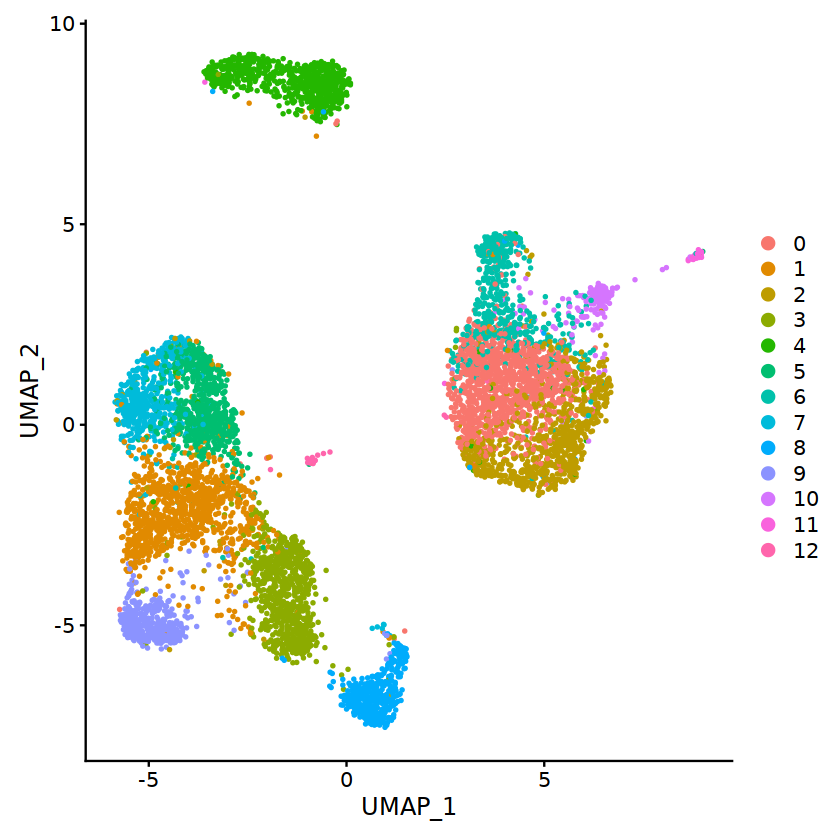

In [52]:
seurat_rds <- readRDS('10X_ATAC/analysis/atac_pbmc_10k_v1_S1_L001/Result/Analysis/atac_pbmc_10k_v1_S1_L001_scATAC_Object.rds')
chromVarResult <- mergeChromVarResult(seurat_rds, z_frame)

In [ ]:
chromVarResult$ATAC@meta.data

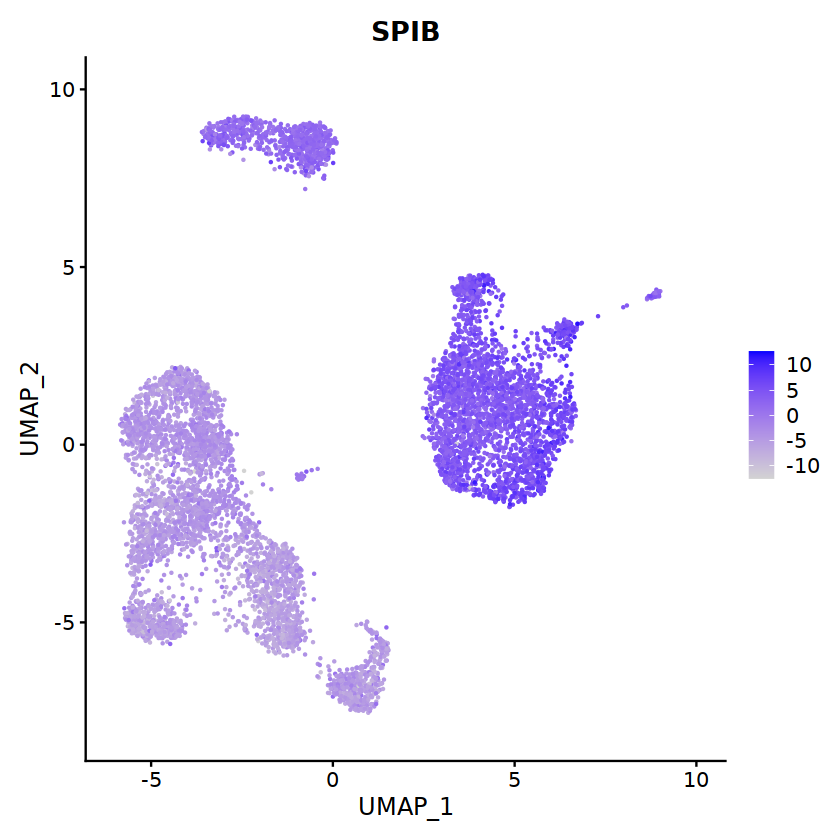

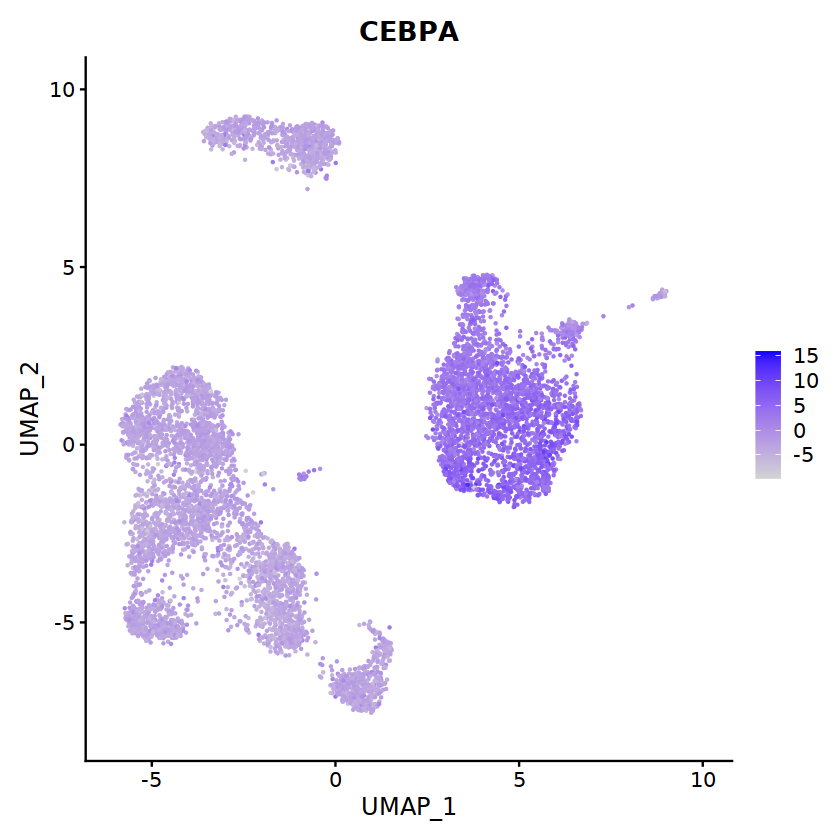

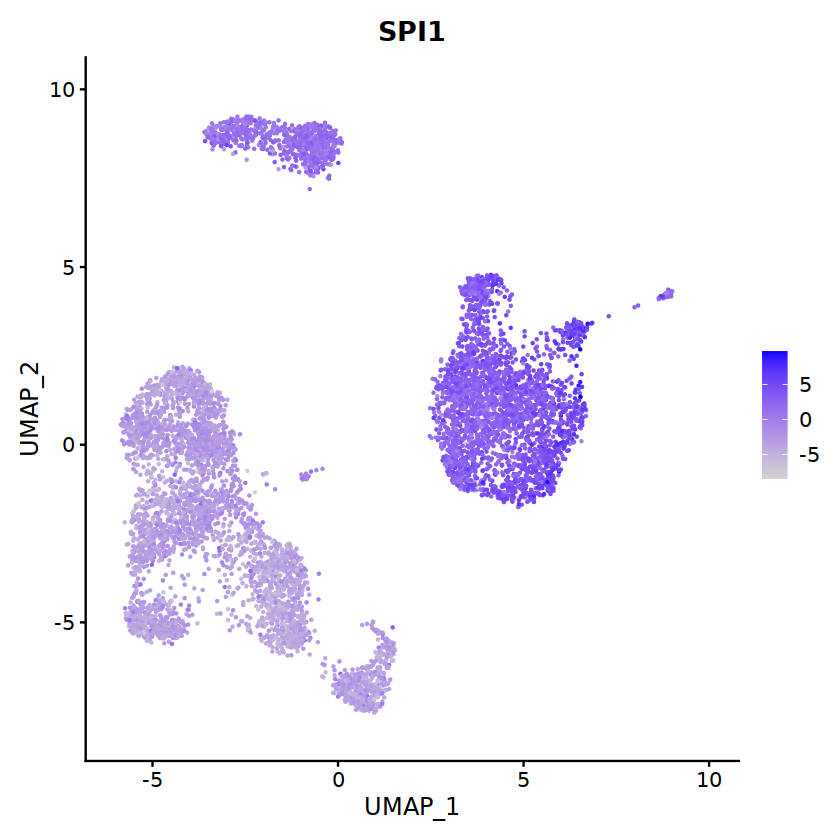

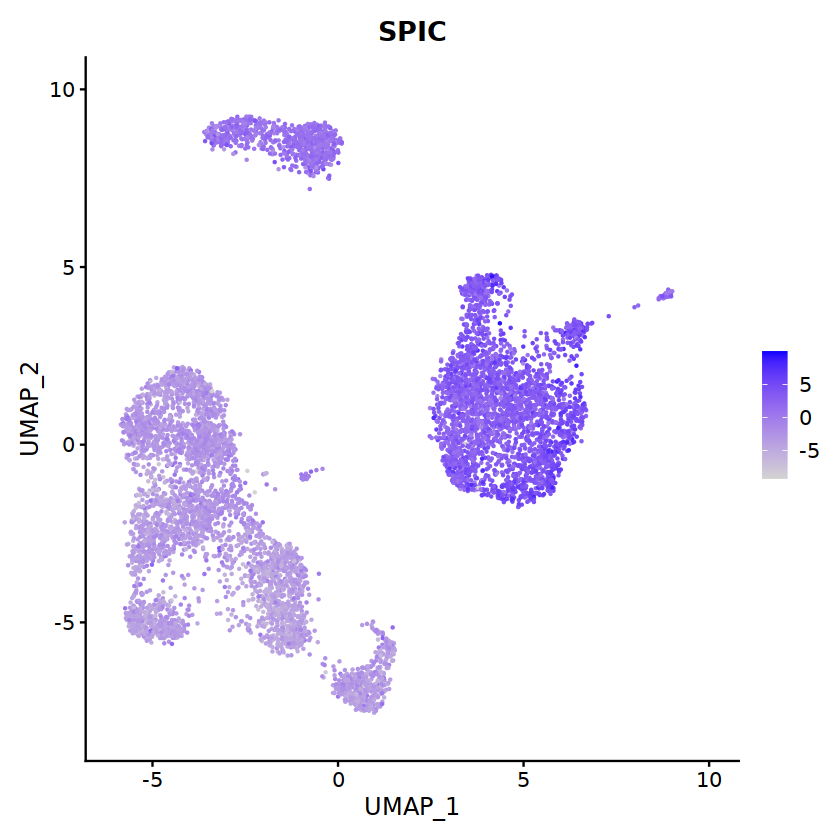

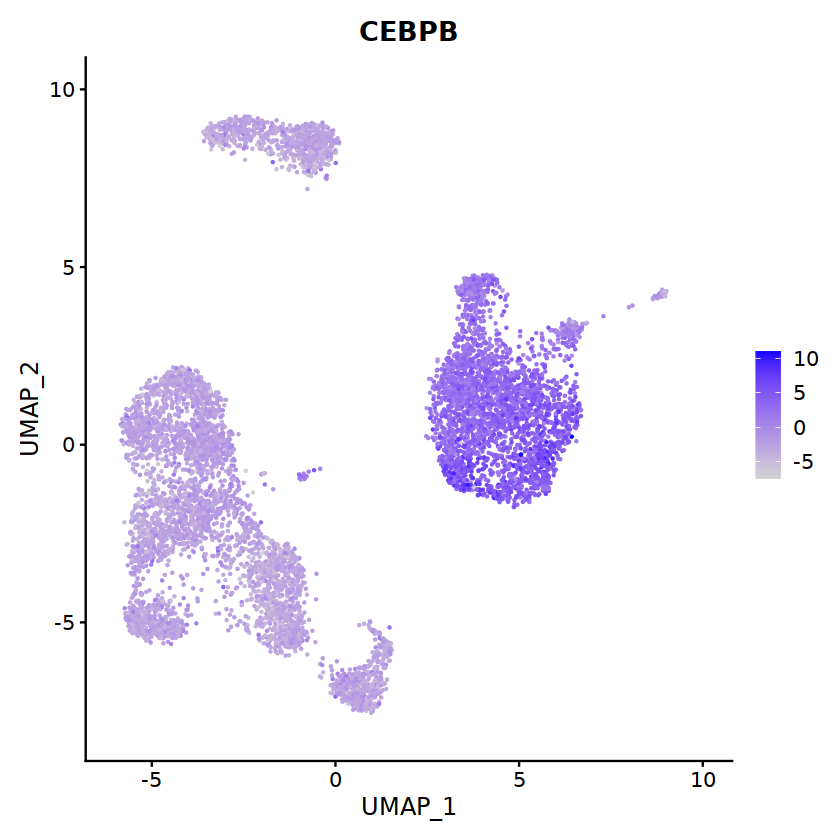

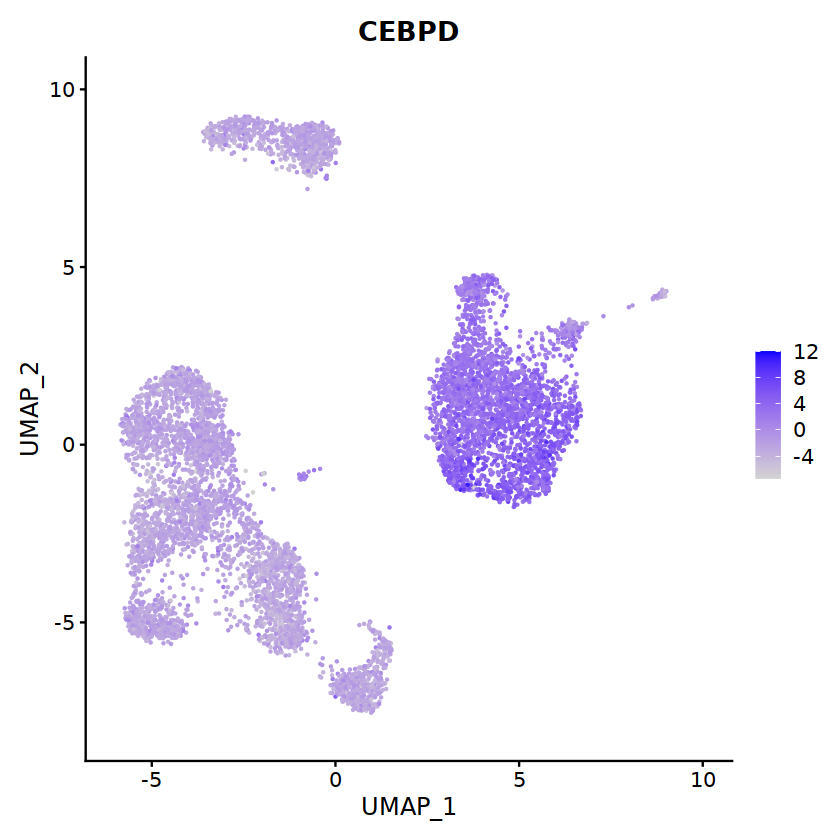

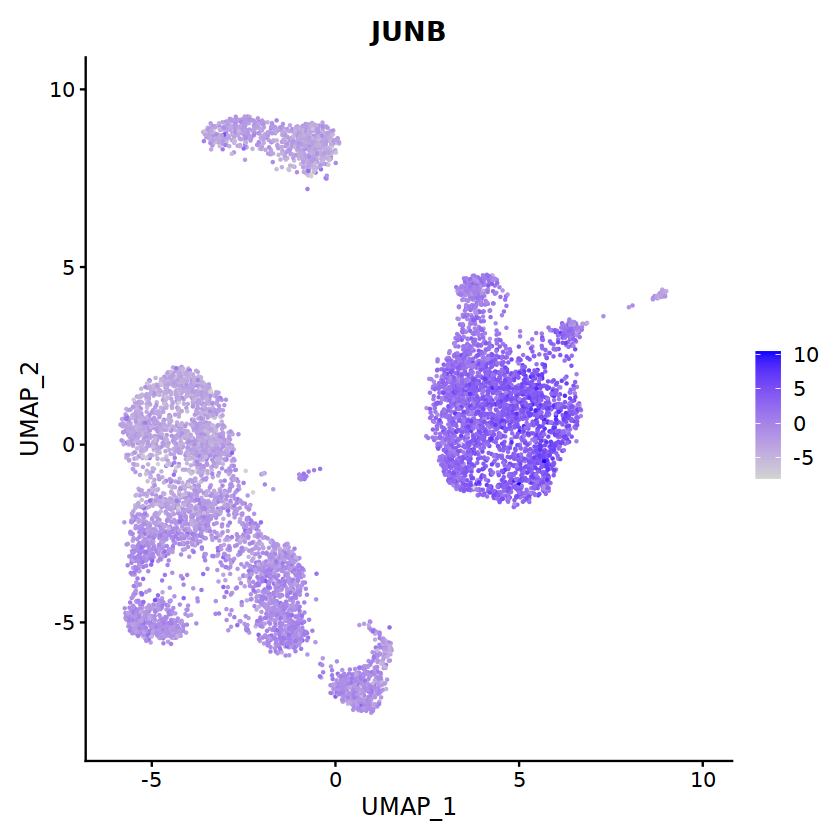

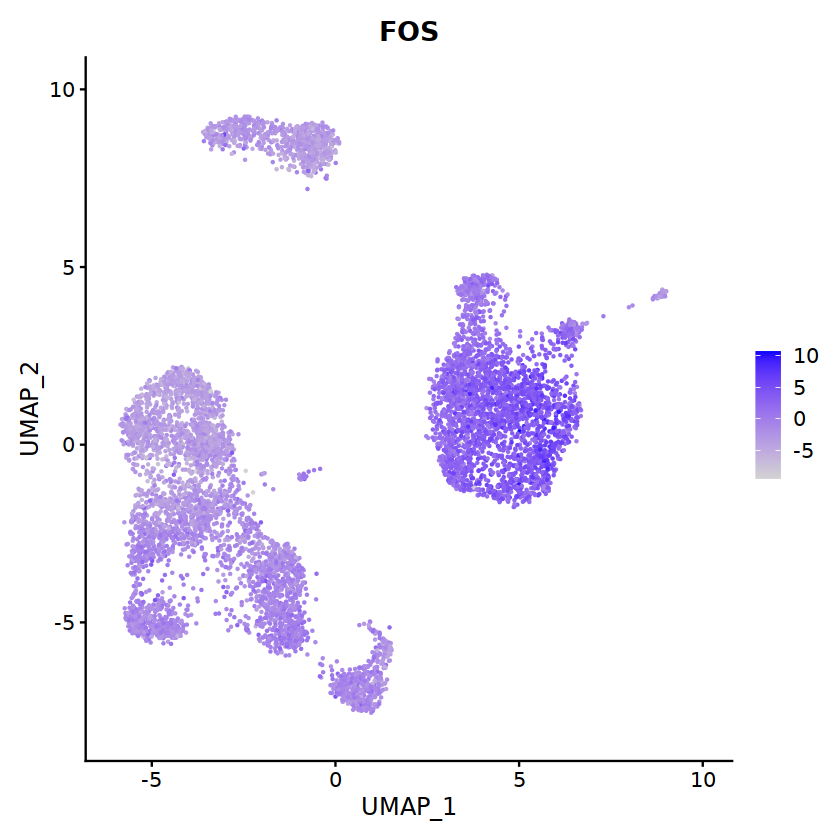

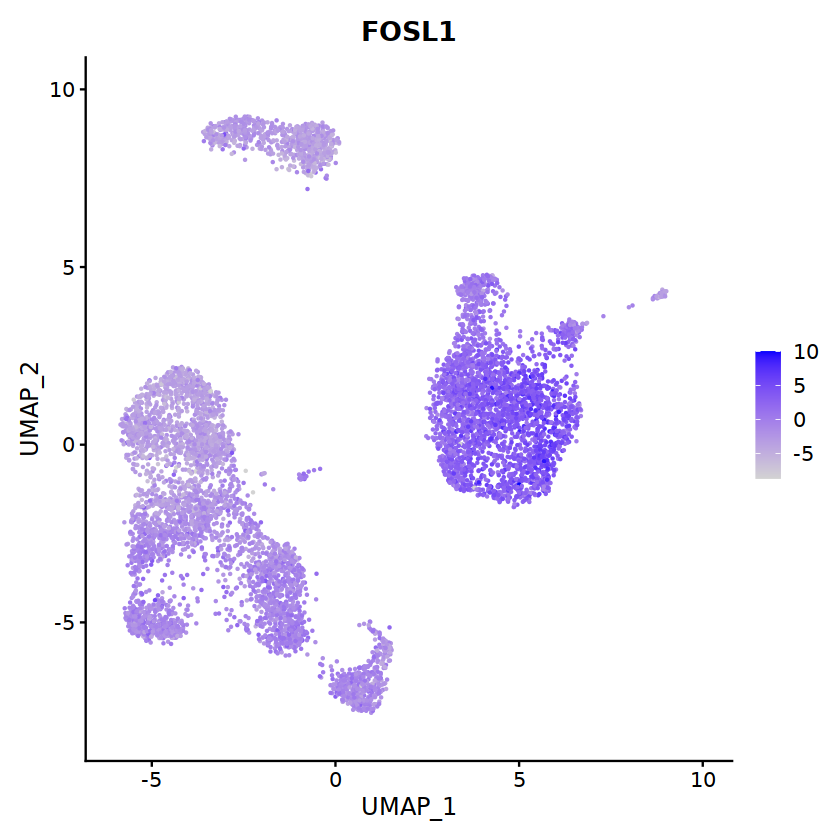

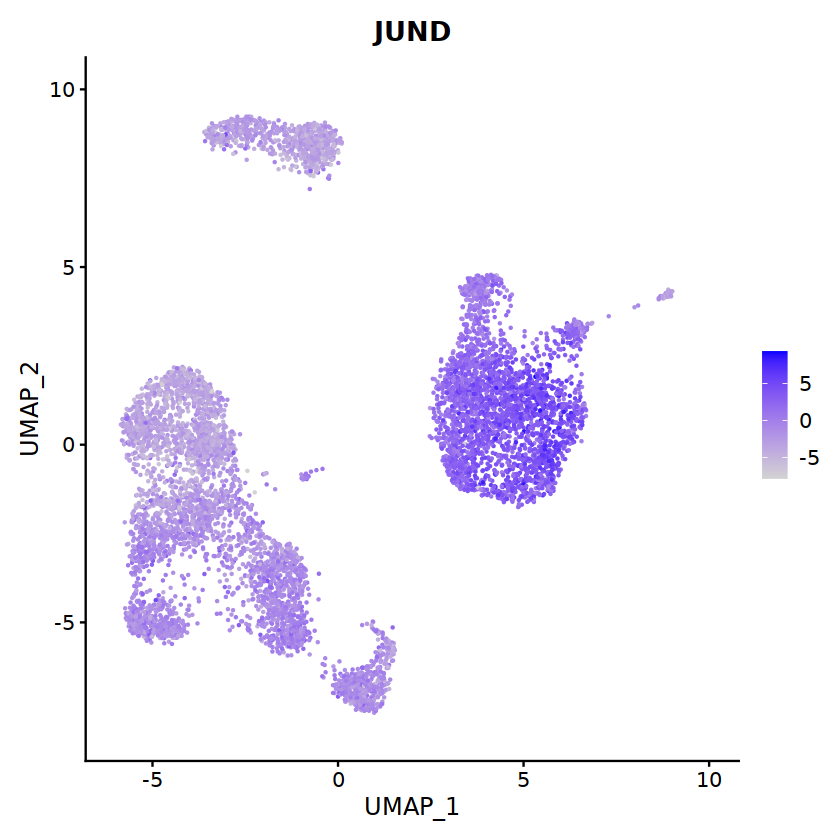

In [49]:
for (i in TFlist) {
    fig <- FeaturePlot(object = chromVarResult$ATAC, feature=i)
    show(fig)
}

In [ ]:
# tmp.path <- "10X_ATAC/chromVAR_result_more_motif.rds"
# tmp <- readRDS(tmp.path)
# qsave(tmp, str_replace(tmp.path, ".rds", ".qs"))

In [ ]:
qsave(chromVarResult, "10X_ATAC/chromVAR_result_more_motif.qs")

In [74]:
chromVarResult <- qread("10X_ATAC/chromVAR_result_more_motif.qs")

# Mouse Brain